
# Analysis of the 2017-2018 schol year kindergarten lottery

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#questions">Questions about the data set</a></li>
</ul>


<a id='intro'></a>
## Introduction

4,611 children entered the 2017-2018 San Francisco Unified School District kindergarten lottery. Parents can select multiple schools, and they made more than 45,000 unique choices. 
This Jupyter Noteboook reviews data analyzed by KQED for this news article: https://www.kqed.org/news/11641019/s-f-s-kindergarten-lottery-do-parents-tricks-work, using this base workbook: https://github.com/pickoffwhite/San-Francisco-Kindergarten-Lottery

In addition the the baseline review, already set forth by the KQED team, this notebook looks at 
* those applications that listed three schools 
* the impact of zipcode and CTIP status on choices, assignments, and enrollments

Data limitations: Additional data would help ascertain how selections connect with language requirements for the bilitieracy and immersion programs. And, additional data can help assess how AA and sibling preference impact assignments and enrollment. 

In [1]:
# Importing packages and functions
import pandas as pd
import numpy as np
import datetime # operations to parse dates
import time
import csv
from pprint import pprint #for pretty printing dictionaries
#import ggplot as gplot
import matplotlib as mpl # Still required to change the sizes of plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
lotto = pd.read_csv('./data/kqed_data/20171103_KQED_KinderAssignmentData_201718_k_placement_2017_2018.csv', dtype = object)
df=lotto.copy()

In [3]:
lotto.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4611 entries, 0 to 4610
Data columns (total 98 columns):
StudentNo                                 4611 non-null object
1                                         4611 non-null object
2                                         3856 non-null object
3                                         3441 non-null object
4                                         3028 non-null object
5                                         2657 non-null object
6                                         2361 non-null object
7                                         2114 non-null object
8                                         1938 non-null object
9                                         1804 non-null object
10                                        1668 non-null object
11                                        1147 non-null object
12                                        1027 non-null object
13                                        992 non-null object
14          

In [4]:
lotto.duplicated().sum()

0

In [5]:
lotto.nunique().sum()

8892

In [6]:
lotto.head()

,StudentNo,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,Round 1 Assignment,School Enrolled In As Of 11/03/2017,Student's Ethnicity,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code
0,1,848,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,848,848,"White, Not of Hispanic Origin",N,94118
1,2,420,420,537,729,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,729,729,Hispanic,N,94112
2,3,478,589,722,664,539,796,420,413,569,...,NaN,NaN,NaN,NaN,NaN,722,722,"White, Not of Hispanic Origin",N,94131
3,4,782,676,478,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,782,782,Asian or Pacific Islander,N,94127
4,5,420,618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,420,420,Hispanic,Y,94110


# Data Cleaning

### Manage CTIP column 

In [7]:
#seperate out the data columns that I will be working with 
zipdata = df.iloc[:, [0,93,94,96,97]]
zipdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4611 entries, 0 to 4610
Data columns (total 5 columns):
StudentNo                                 4611 non-null object
Round 1 Assignment                        4470 non-null object
School Enrolled In As Of 11/03/2017       4043 non-null object
Does Student Live In CTIP1 Zone? (y/n)    4611 non-null object
Student's Residential Zip Code            4611 non-null object
dtypes: object(5)
memory usage: 180.2+ KB


In [8]:
#convert data types
zipdata = zipdata.convert_objects(convert_numeric=True)
zipdata.dtypes

/Users/Irene/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


StudentNo                                   int64
Round 1 Assignment                        float64
School Enrolled In As Of 11/03/2017       float64
Does Student Live In CTIP1 Zone? (y/n)     object
Student's Residential Zip Code              int64
dtype: object

In [9]:
#Replace 'Y' and 'N' with 1 and 0 for 'Not CTIP'
  #1 = yes CTIP #0 = is not a CTIP applicant
zipdata['Does Student Live In CTIP1 Zone? (y/n)'].replace({'N':0, 'Y': 1}, inplace=True)

In [10]:
zipdata.dtypes

StudentNo                                   int64
Round 1 Assignment                        float64
School Enrolled In As Of 11/03/2017       float64
Does Student Live In CTIP1 Zone? (y/n)      int64
Student's Residential Zip Code              int64
dtype: object

In [11]:
pd.options.display.float_format = '{:,.0f}'.format

In [12]:
zipdata.head()

,StudentNo,Round 1 Assignment,School Enrolled In As Of 11/03/2017,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code
0,1,848,848,0,94118
1,2,729,729,0,94112
2,3,722,722,0,94131
3,4,782,782,0,94127
4,5,420,420,1,94110


<a id='questions'></a>
# Questions about the data

## Which are the top most requested schools?

## How many students enrolled in their Round 1 top choice school?

> **2810 students... 60.94% of students** 

There are students that entered the lottery late. The school that those students enroll in becomes their first choice in the data. We are going to exclude them from the dataset. We can tell who they are because they did not received a round one assignment, so their data is null, according to the San Francisco School District. This year there were 141 students that entered the lotter late. 

In [13]:
late = lotto['Round 1 Assignment']
late.isna().sum()

141

In [14]:
lotto.dropna(subset=['Round 1 Assignment']) 

,StudentNo,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,Round 1 Assignment,School Enrolled In As Of 11/03/2017,Student's Ethnicity,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code
0,1,848,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,848,848,"White, Not of Hispanic Origin",N,94118
1,2,420,420,537,729,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,729,729,Hispanic,N,94112
2,3,478,589,722,664,539,796,420,413,569,...,NaN,NaN,NaN,NaN,NaN,722,722,"White, Not of Hispanic Origin",N,94131
3,4,782,676,478,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,782,782,Asian or Pacific Islander,N,94127
4,5,420,618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,420,420,Hispanic,Y,94110
5,6,838,746,478,876,488,848,729,569,796,...,NaN,NaN,NaN,NaN,NaN,838,838,Asian or Pacific Islander,N,94134
6,7,485,876,513,513,478,862,862,782,760,...,NaN,NaN,NaN,NaN,NaN,760,614,Declines To State,N,94134
7,8,859,449,790,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,859,859,Hispanic,N,94102
8,9,420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,420,420,Declines To State,Y,94107
9,10,782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,782,782,Declines To State,N,94112


In [15]:
lotto['got1stchoice'] = np.where(lotto['1'] == lotto['School Enrolled In As Of 11/03/2017'], 'yes', 'no')

In [16]:
lotto.got1stchoice.value_counts()

yes    2810
no     1801
Name: got1stchoice, dtype: int64

In [17]:
lotto.got1stchoice.value_counts('yes')

yes   1
no    0
Name: got1stchoice, dtype: float64

## How many students enrolled in one of the schools in their first three, five, and ten choices. 
We're filtering down the dataframe to the first five schools, and then seeing how many match.

> **Top 3: 73%** 

> **Top 5: 76%** 

> **Top 10: 79%** 

In [18]:
lotto2 = lotto[['School Enrolled In As Of 11/03/2017','1','2']]

In [19]:
lotto['gottop2'] = lotto2.drop("School Enrolled In As Of 11/03/2017", 1).isin(lotto2["School Enrolled In As Of 11/03/2017"]).any(1)

In [20]:
lotto.gottop2.value_counts(True)

True    1
False   0
Name: gottop2, dtype: float64

In [21]:
lotto3 = lotto[['School Enrolled In As Of 11/03/2017','1','2','3']]

In [22]:
lotto['gottop3'] = lotto3.drop("School Enrolled In As Of 11/03/2017", 1).isin(lotto3["School Enrolled In As Of 11/03/2017"]).any(1)

In [23]:
lotto.gottop3.value_counts(True)

True    1
False   0
Name: gottop3, dtype: float64

How many students enrolled in one of the schools in their top 5 schools. We're filtering down the dataframe to the first ten schools, and then seeing how many match.

In [24]:
lotto5 = lotto[['School Enrolled In As Of 11/03/2017','1','2','3','4','5']]

In [25]:
lotto['gottop5'] = lotto5.drop("School Enrolled In As Of 11/03/2017", 1).isin(lotto5["School Enrolled In As Of 11/03/2017"]).any(1)

In [26]:
lotto.gottop5.value_counts(True)

True    1
False   0
Name: gottop5, dtype: float64

How many students enrolled in one of the schools in their top 10 choices. 
We're filtering down the dataframe to the first ten schools, and then seeing how many match.

In [27]:
lotto10 = lotto[['School Enrolled In As Of 11/03/2017','1','2','3','4','5', '6', '7', '8', '9', '10']]

In [28]:
lotto['gottop10'] = lotto10.drop("School Enrolled In As Of 11/03/2017", 1).isin(lotto10["School Enrolled In As Of 11/03/2017"]).any(1)


In [29]:
lotto.gottop10.value_counts(True)

True    1
False   0
Name: gottop10, dtype: float64

In [30]:
lotto.reset_index()

,index,StudentNo,1,2,3,4,5,6,7,8,...,Round 1 Assignment,School Enrolled In As Of 11/03/2017,Student's Ethnicity,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code,got1stchoice,gottop2,gottop3,gottop5,gottop10
0,0,1,848,569,NaN,NaN,NaN,NaN,NaN,NaN,...,848,848,"White, Not of Hispanic Origin",N,94118,yes,True,True,True,True
1,1,2,420,420,537,729,NaN,NaN,NaN,NaN,...,729,729,Hispanic,N,94112,no,False,False,True,True
2,2,3,478,589,722,664,539,796,420,413,...,722,722,"White, Not of Hispanic Origin",N,94131,no,False,True,True,True
3,3,4,782,676,478,NaN,NaN,NaN,NaN,NaN,...,782,782,Asian or Pacific Islander,N,94127,yes,True,True,True,True
4,4,5,420,618,NaN,NaN,NaN,NaN,NaN,NaN,...,420,420,Hispanic,Y,94110,yes,True,True,True,True
5,5,6,838,746,478,876,488,848,729,569,...,838,838,Asian or Pacific Islander,N,94134,yes,True,True,True,True
6,6,7,485,876,513,513,478,862,862,782,...,760,614,Declines To State,N,94134,no,False,False,False,False
7,7,8,859,449,790,NaN,NaN,NaN,NaN,NaN,...,859,859,Hispanic,N,94102,yes,True,True,True,True
8,8,9,420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,420,420,Declines To State,Y,94107,yes,True,True,True,True
9,9,10,782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,782,782,Declines To State,N,94112,yes,True,True,True,True


## How many students are assigned a school not in their list in round one?

> **3% of students were assigned a school not listed in their list of selected schools** 

In [31]:
randomAssignment = lotto.drop(['StudentNo', 'School Enrolled In As Of 11/03/2017'], axis=1)

In [32]:
randomAssignment['notrandom'] = randomAssignment.drop('Round 1 Assignment', 1).isin(randomAssignment['Round 1 Assignment']).any(1)

In [33]:
randomAssignment.notrandom.value_counts(False)

True     4470
False     141
Name: notrandom, dtype: int64

## How many people put down more than 5, 10 school choices?

> **57% listed more than 5 choices** 

> **36% listed more than 10 choices** 

In [34]:
amountchoices = lotto.drop(['StudentNo', "Does Student Live In CTIP1 Zone? (y/n)",'School Enrolled In As Of 11/03/2017', 'Round 1 Assignment', "Student's Ethnicity", "Student's Residential Zip Code", 'got1stchoice', 'gottop5', 'gottop10'], axis=1)

In [35]:
lotto['choices'] = amountchoices.notnull().sum(axis=1)

In [36]:
lotto['morethan3'] = np.where(lotto['choices'] > 3, 'yes', 'no')

In [37]:
lotto.morethan3.value_counts('yes')

yes   1
no    0
Name: morethan3, dtype: float64

In [38]:
lotto['morethan5'] = np.where(lotto['choices'] > 5, 'yes', 'no')

In [39]:
lotto.morethan5.value_counts()

yes    3028
no     1583
Name: morethan5, dtype: int64

In [40]:
lotto.morethan5.value_counts('yes')

yes   1
no    0
Name: morethan5, dtype: float64

In [41]:
lotto['morethan10'] = np.where(lotto['choices'] > 10, 'yes', 'no')

In [42]:
lotto.morethan10.value_counts()

no     2807
yes    1804
Name: morethan10, dtype: int64

In [43]:
lotto.morethan10.value_counts('yes')

no    1
yes   0
Name: morethan10, dtype: float64

In [44]:
lotto['lessthan10'] = np.where(lotto['choices'] < 10, 'yes', 'no')

In [45]:
lotto.lessthan10.value_counts('yes')

yes   1
no    0
Name: lessthan10, dtype: float64

In [46]:
lotto['lessthan5'] = np.where(lotto['choices'] < 5, 'yes', 'no')

In [47]:
lotto.lessthan5.value_counts('yes')

no    1
yes   0
Name: lessthan5, dtype: float64

## Does putting down more than ten schools impact the chance of enrolling in your first choice?

In [48]:
lotto.groupby(['got1stchoice', 'morethan10']).size()

got1stchoice  morethan10
no            no             769
              yes           1032
yes           no            2038
              yes            772
dtype: int64

In [49]:
lotto.groupby(['got1stchoice', 'morethan5']).size()

got1stchoice  morethan5
no            no            243
              yes          1558
yes           no           1340
              yes          1470
dtype: int64

In [50]:
lotto.groupby(['got1stchoice', 'lessthan5']).size()

got1stchoice  lessthan5
no            no           1683
              yes           118
yes           no           1758
              yes          1052
dtype: int64

In [51]:
lotto.head()

,StudentNo,1,2,3,4,5,6,7,8,9,...,gottop2,gottop3,gottop5,gottop10,choices,morethan3,morethan5,morethan10,lessthan10,lessthan5
0,1,848,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,4,yes,no,no,yes,yes
1,2,420,420,537,729,NaN,NaN,NaN,NaN,NaN,...,False,False,True,True,6,yes,yes,no,yes,no
2,3,478,589,722,664,539,796,420,413,569,...,False,True,True,True,17,yes,yes,yes,no,no
3,4,782,676,478,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,5,yes,no,no,yes,no
4,5,420,618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,4,yes,no,no,yes,yes


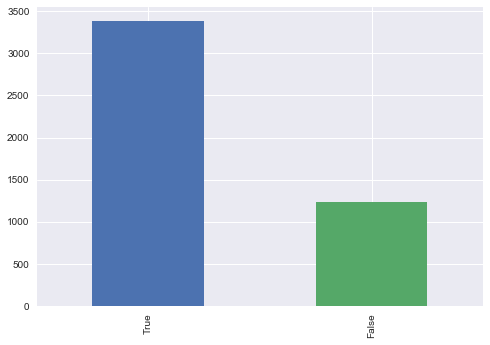

In [52]:
lotto['gottop3'].value_counts().plot(kind='bar');

# Export data

In [53]:
lotto.to_csv('./data/exports/lotto_edited.csv')

In [54]:
zipdata.to_csv('./data/exports/zipdata.csv')

## CTIP

## How many CTIP applicants are there?

> **705** 

In [55]:
zipdata['Does Student Live In CTIP1 Zone? (y/n)'].value_counts()

0    3906
1     705
Name: Does Student Live In CTIP1 Zone? (y/n), dtype: int64

## Did any of the CTIP applicants apply late?

> **no** 

In [56]:
ctip_1 = zipdata[(zipdata['Does Student Live In CTIP1 Zone? (y/n)']==1)]
print(ctip_1)

      StudentNo  Round 1 Assignment  School Enrolled In As Of 11/03/2017  \
4             5                 420                                  420   
8             9                 420                                  420   
11           12                 676                                  676   
35           36                 485                                  485   
36           37                 760                                  760   
49           50                 723                                  723   
55           56                 420                                  420   
66           67                 603                                  603   
69           70                 714                                  517   
78           79                 786                                  786   
92           93                 680                                  680   
97           98                 420                                  420   
98          

In [57]:
ctip_late = ctip_1['Round 1 Assignment']
ctip_late.isna().sum()

0

## How many CTIP applicants were assigned their top choice school? compared to non CTIP applicants?

> **14% or 88 CTIP applicants out of 705 received their top choice school in the first round...compared to 46% of non CTIP applicants** Note: non CTIP applicants includes AA designation students and students with an older sibling already at their top choice school...both factors would increase their likelihood of receiving their top choice according to SF Parents For Public Schools. 

In [58]:
zipdata['got1stchoice'] = np.where(zipdata['Round 1 Assignment'] == zipdata['School Enrolled In As Of 11/03/2017'], 0, 1)

In [59]:
zipdata.head()

,StudentNo,Round 1 Assignment,School Enrolled In As Of 11/03/2017,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code,got1stchoice
0,1,848,848,0,94118,0
1,2,729,729,0,94112,0
2,3,722,722,0,94131,0
3,4,782,782,0,94127,0
4,5,420,420,1,94110,0


In [60]:
zipdata.groupby(['Does Student Live In CTIP1 Zone? (y/n)', 'got1stchoice']).size()

Does Student Live In CTIP1 Zone? (y/n)  got1stchoice
0                                       0               2667
                                        1               1239
1                                       0                617
                                        1                 88
dtype: int64

## Where did CTIP applicants end up?

In [61]:
codes = pd.read_csv('./data/codes/master_schools_list_complete.csv')
df_codes = codes.copy()

In [62]:
codes.head()

,Unnamed: 0,school_name_x,district_code,cds_code,school_name_y,campus_address,zipcode
0,0,Alamo ES,413,6040695,Alamo Elementary School,250 23RD AVE,94121
1,84,Alice Fong Yu ES,801,6113245,"Yu, Alice Fong Yu Alternative School",1541 12TH AVE,94122
2,1,Alvarado ES,420,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114
3,2,Argonne ES,435,6040737,Argonne Elementary School,680 18TH AVE,94121
4,3,Bryant ES,456,6040778,Bryant Early Education / Bryant Elementary,2641 25TH ST,94110


In [63]:
codes.rename(columns={'zipcode' : 'campus_zipcode'}, inplace=True)

In [64]:
codes.columns

Index(['Unnamed: 0', 'school_name_x', 'district_code', 'cds_code',
       'school_name_y', 'campus_address', 'campus_zipcode'],
      dtype='object')

In [65]:
codes = codes.infer_objects()

In [66]:
codes.columns

Index(['Unnamed: 0', 'school_name_x', 'district_code', 'cds_code',
       'school_name_y', 'campus_address', 'campus_zipcode'],
      dtype='object')

In [67]:
codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
Unnamed: 0        85 non-null int64
school_name_x     85 non-null object
district_code     85 non-null int64
cds_code          85 non-null int64
school_name_y     84 non-null object
campus_address    84 non-null object
campus_zipcode    85 non-null int64
dtypes: int64(4), object(3)
memory usage: 4.7+ KB


In [68]:
codes.head()

,Unnamed: 0,school_name_x,district_code,cds_code,school_name_y,campus_address,campus_zipcode
0,0,Alamo ES,413,6040695,Alamo Elementary School,250 23RD AVE,94121
1,84,Alice Fong Yu ES,801,6113245,"Yu, Alice Fong Yu Alternative School",1541 12TH AVE,94122
2,1,Alvarado ES,420,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114
3,2,Argonne ES,435,6040737,Argonne Elementary School,680 18TH AVE,94121
4,3,Bryant ES,456,6040778,Bryant Early Education / Bryant Elementary,2641 25TH ST,94110


In [69]:
ctip_1.head()

,StudentNo,Round 1 Assignment,School Enrolled In As Of 11/03/2017,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code
4,5,420,420,1,94110
8,9,420,420,1,94107
11,12,676,676,1,94107
35,36,485,485,1,94124
36,37,760,760,1,94124


In [70]:
ctip_enrolled = ctip_1.drop(['Round 1 Assignment'], axis=1)

In [71]:
ctip_enrolled.head()

,StudentNo,School Enrolled In As Of 11/03/2017,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code
4,5,420,1,94110
8,9,420,1,94107
11,12,676,1,94107
35,36,485,1,94124
36,37,760,1,94124


In [72]:
ctip_enrolled.rename(columns={'School Enrolled In As Of 11/03/2017' : 'district_code'}, inplace=True)

In [73]:
ctip_enrolled_w_school_zip = pd.merge(ctip_enrolled, codes, on='district_code', how='outer')

In [74]:
ctip_enrolled_w_school_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 10 columns):
StudentNo                                 739 non-null float64
district_code                             727 non-null float64
Does Student Live In CTIP1 Zone? (y/n)    739 non-null float64
Student's Residential Zip Code            739 non-null float64
Unnamed: 0                                694 non-null float64
school_name_x                             694 non-null object
cds_code                                  694 non-null float64
school_name_y                             690 non-null object
campus_address                            690 non-null object
campus_zipcode                            694 non-null float64
dtypes: float64(7), object(3)
memory usage: 64.8+ KB


In [75]:
ctip_enrolled_w_school_zip['campus_zipcode'] = ctip_enrolled_w_school_zip['campus_zipcode'].fillna(0).astype(int)
ctip_enrolled_w_school_zip['campus_zipcode'] = ctip_enrolled_w_school_zip['campus_zipcode'].astype(np.int64)
ctip_enrolled_w_school_zip['Student\'s Residential Zip Code'] = ctip_enrolled_w_school_zip['Student\'s Residential Zip Code'].fillna(0).astype(int)
ctip_enrolled_w_school_zip['Student\'s Residential Zip Code'] = ctip_enrolled_w_school_zip['Student\'s Residential Zip Code'].astype(np.int64)
ctip_enrolled_w_school_zip['cds_code'] = ctip_enrolled_w_school_zip['cds_code'].fillna(0).astype(int)
ctip_enrolled_w_school_zip['cds_code'] = ctip_enrolled_w_school_zip['cds_code'].astype(np.int64)

In [76]:
ctip_enrolled_w_school_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 10 columns):
StudentNo                                 739 non-null float64
district_code                             727 non-null float64
Does Student Live In CTIP1 Zone? (y/n)    739 non-null float64
Student's Residential Zip Code            754 non-null int64
Unnamed: 0                                694 non-null float64
school_name_x                             694 non-null object
cds_code                                  754 non-null int64
school_name_y                             690 non-null object
campus_address                            690 non-null object
campus_zipcode                            754 non-null int64
dtypes: float64(4), int64(3), object(3)
memory usage: 64.8+ KB


In [77]:
ctip_enrolled_w_school_zip.head()

,StudentNo,district_code,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code,Unnamed: 0,school_name_x,cds_code,school_name_y,campus_address,campus_zipcode
0,5,420,1,94110,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114
1,9,420,1,94107,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114
2,56,420,1,94110,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114
3,98,420,1,94110,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114
4,169,420,1,94107,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114


In [78]:
ctip_enrolled_w_school_zip['enrolled_in_home_zipcode'] = np.where(ctip_enrolled_w_school_zip['Student\'s Residential Zip Code'] == ctip_enrolled_w_school_zip['campus_zipcode'], 0, 1)

In [79]:
ctip_enrolled_w_school_zip.head()

,StudentNo,district_code,Does Student Live In CTIP1 Zone? (y/n),Student's Residential Zip Code,Unnamed: 0,school_name_x,cds_code,school_name_y,campus_address,campus_zipcode,enrolled_in_home_zipcode
0,5,420,1,94110,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114,1
1,9,420,1,94107,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114,1
2,56,420,1,94110,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114,1
3,98,420,1,94110,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114,1
4,169,420,1,94107,1,Alvarado ES,6040703,Alvarado Elementary School,625 DOUGLASS ST,94114,1


In [80]:
ctip_enrolled_w_school_zip.enrolled_in_home_zipcode.value_counts()

1    559
0    195
Name: enrolled_in_home_zipcode, dtype: int64

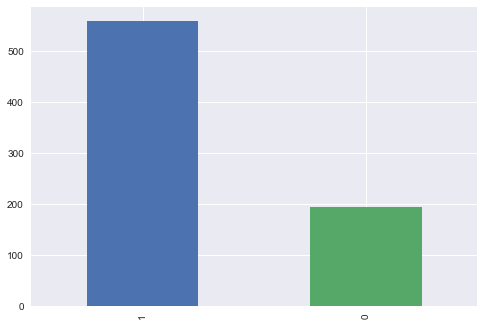

In [82]:
ctip_enrolled_w_school_zip['enrolled_in_home_zipcode'].value_counts().plot(kind='bar');

In [83]:
import pdfkit
pdfkit.from_file('KQED_SanFrancisco_kindergarten_lottery.html', 'KQED_SanFrancisco_kindergarten_lottery.pdf')

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                        


True